In [ ]:
 
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('./drive/MyDrive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip ./drive/MyDrive/PNG.zip -d .
!unzip ./drive/MyDrive/kvasir-seg.zip -d .

Archive:  ./drive/MyDrive/kvasir-seg.zip
   creating: ./Kvasir-SEG/
  inflating: ./Kvasir-SEG/kavsir_bboxes.json  
   creating: ./Kvasir-SEG/images/
  inflating: ./Kvasir-SEG/images/ck2bxiswtxuw80838qkisqjwz.jpg  
  inflating: ./Kvasir-SEG/images/ck2bxknhjvs1x0794iogrq49k.jpg  
  inflating: ./Kvasir-SEG/images/ck2bxlujamu330725szlc2jdu.jpg  
  inflating: ./Kvasir-SEG/images/ck2bxpfgxu2mk0748gsh7xelu.jpg  
  inflating: ./Kvasir-SEG/images/ck2bxqz3evvg20794iiyv5v2m.jpg  
  inflating: ./Kvasir-SEG/images/ck2bxskgxxzfv08386xkqtqdy.jpg  
  inflating: ./Kvasir-SEG/images/ck2bxw18mmz1k0725litqq2mc.jpg  
  inflating: ./Kvasir-SEG/images/ck2395w2mb4vu07480otsu6tw.jpg  
  inflating: ./Kvasir-SEG/images/ck2da7fwcjfis07218r1rvm95.jpg  
  inflating: ./Kvasir-SEG/images/cjyzjzssvd8pq0838f4nolj5l.jpg  
  inflating: ./Kvasir-SEG/images/cjyzk8qieoboa0848ogj51wwm.jpg  
  inflating: ./Kvasir-SEG/images/cju5hi52odyf90817prvcwg45.jpg  
  inflating: ./Kvasir-SEG/images/cju5hjxaae3i40850h5z2laf5.jpg  
  infl

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras import Model
import tensorflow as tf

In [ ]:
image_names= os.listdir("./Kvasir-SEG/images")
mask_names= os.listdir("./Kvasir-SEG/masks")

In [ ]:
image_names.sort()
mask_names.sort()

In [ ]:
len(image_names)

1000

In [ ]:
rel_image= []
rel_mask= []

In [ ]:
for i in image_names:
    
    #p= os.path.join("./Original", i)
    p= os.path.join("./Kvasir-SEG/images", i)
    rel_image.append(p)
    
for i in mask_names:
    
    #p= os.path.join("./Ground Truth", i)
    p= os.path.join("./Kvasir-SEG/masks", i)
    rel_mask.append(p)

In [ ]:
def load_data(data_path):
    
    images= []
    
    for i in data_path:
        x= Image.open(i)
        
        x= x.resize((256, 256))
        
        x= np.array(x)

        images.append(x)
        
    images= np.array(images)
    print("Done")
    return images

In [ ]:
from skimage import color
from skimage import io


def load_data_grey(data_path):
    
    images= []
    
    for i in data_path:
        x= Image.open(i)
        x= x.resize((256, 256))
        
        x= np.array(x)
        x=color.rgb2gray(x)
        images.append(x)
        
    images= np.array(images)
    print("Done")
    return images

In [ ]:
x_train= load_data(rel_image[:590])
y_train= load_data_grey(rel_mask[: 590])
x_test= load_data(rel_image[590: 609])
y_test= load_data_grey(rel_mask[590: 609])

Done
Done
Done
Done


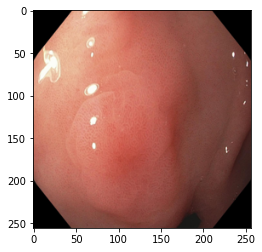

(590, 256, 256, 3)


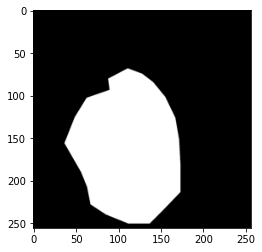

In [ ]:
plt.imshow(x_train[1])
plt.show()
print(x_train.shape)
plt.imshow(y_train[1, :, :], cmap= "gray")
plt.show()

In [ ]:
y_test.shape

(19, 256, 256)

In [ ]:
y_train= y_train.reshape((590, 256, 256, 1))
y_test= y_test.reshape((19, 256, 256, 1))


In [ ]:
y_test.shape, y_train.shape

((19, 256, 256, 1), (590, 256, 256, 1))

In [ ]:
def build_unet(shape):
    input_layer = Input(shape = shape)
    
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_layer)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(conv5), conv4], axis = 3)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up6)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv6), conv3], axis = 3)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up7)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv7), conv2], axis = 3)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up8)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv8), conv1], axis = 3)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up9)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)
    
    return Model(input_layer, conv10)

In [ ]:
model= build_unet((256, 256, 3))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(optimizer= "adam", loss= "binary_crossentropy", metrics= ["acc"])

In [ ]:
batchSize= 10
h = model.fit(x_train, y_train, epochs= 300, batch_size= batchSize, validation_data= (x_test, y_test))

Epoch 1/300
59/59 [==============================] - 44s 464ms/step - loss: 0.7996 - acc: 0.8060 - val_loss: 0.4076 - val_acc: 0.8761
Epoch 2/300
59/59 [==============================] - 25s 416ms/step - loss: 0.4466 - acc: 0.8427 - val_loss: 0.3952 - val_acc: 0.8788
Epoch 3/300
59/59 [==============================] - 25s 417ms/step - loss: 0.4287 - acc: 0.8458 - val_loss: 0.3954 - val_acc: 0.8796
Epoch 4/300
59/59 [==============================] - 25s 419ms/step - loss: 0.4306 - acc: 0.8444 - val_loss: 0.4038 - val_acc: 0.8795
Epoch 5/300
59/59 [==============================] - 25s 419ms/step - loss: 0.4282 - acc: 0.8449 - val_loss: 0.3704 - val_acc: 0.8794
Epoch 6/300
59/59 [==============================] - 25s 420ms/step - loss: 0.4068 - acc: 0.8467 - val_loss: 0.3361 - val_acc: 0.8794
Epoch 7/300
59/59 [==============================] - 25s 419ms/step - loss: 0.3733 - acc: 0.8476 - val_loss: 0.3252 - val_acc: 0.8802
Epoch 8/300
59/59 [==============================] - 25s 420ms

In [ ]:
def load_image(image_name):
    
    img= Image.open(image_name)
    img= img.resize((256, 256))
    img= np.array(img)
    
    return img

In [ ]:
from skimage import color
from skimage import io
def load_image_grey(image_name):
    
    img= Image.open(image_name)
    img= img.resize((256, 256))
    img= np.array(img)
    img=color.rgb2gray(img)
    
    return img

In [ ]:
test_img= load_image(rel_image[1])
actual_mask= load_image(rel_mask[1])

In [ ]:
img= test_img.reshape((1, 256, 256, 3))

In [ ]:
pred= model.predict(img)

In [ ]:
def plotting(img, title, gray= True):
    
    if gray== True:
        plt.imshow(img[0, : , :,0], cmap= "gray")
        plt.title(title)
        plt.show()
        
    else:
        plt.imshow(img)
        plt.title(title)
        plt.show()

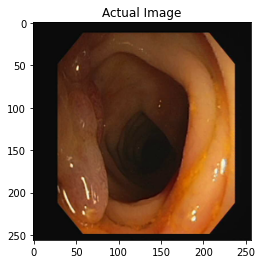

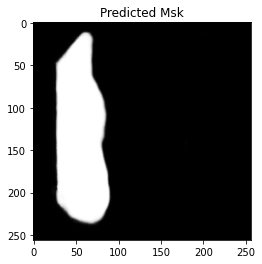

Text(0.5, 1.0, 'Actual Mask')

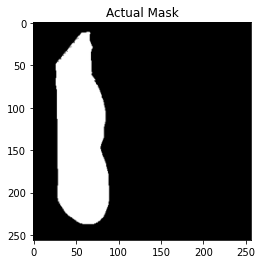

In [ ]:
plotting(test_img, "Actual Image", False)
plotting(pred, "Predicted Msk",True)
plt.imshow(actual_mask, cmap= "gray")
plt.title("Actual Mask")

In [ ]:
model.save("./drive/MyDrive/my_h6_model.h5")

In [ ]:
from keras.models import load_model


model = load_model('./drive/MyDrive/my_h6_model.h5')

In [ ]:
test_img= load_image(rel_image[18])
actual_mask= load_image(rel_mask[18])

In [ ]:
img= test_img.reshape((1, 256, 256, 3))
pred= model.predict(img)

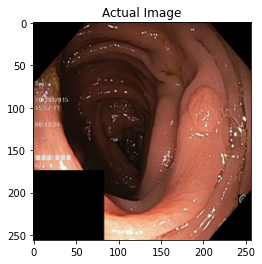

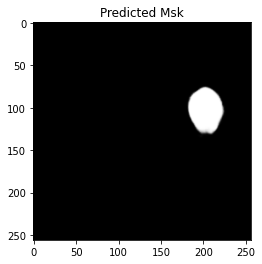

(1, 256, 256, 1)
(256, 256, 3)


Text(0.5, 1.0, 'Actual Mask')

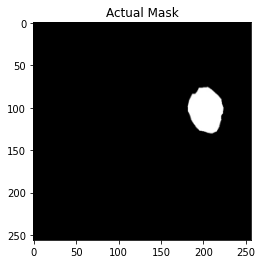

In [ ]:
plotting(test_img, "Actual Image", False)
plotting(pred, "Predicted Msk")
# plt.imshow(pred[0],cmap="gray")
print(pred.shape)
print(actual_mask.shape)
plt.imshow(actual_mask, cmap= "gray")
plt.title("Actual Mask")

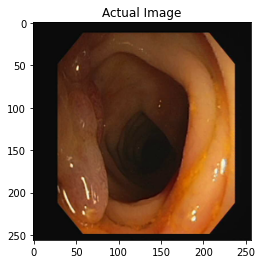

Text(0.5, 1.0, 'Actual Mask')

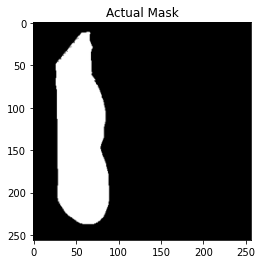

In [ ]:
plotting(load_image(rel_image[1]), "Actual Image", False)
plt.imshow(load_image(rel_mask[1]), cmap= "gray")
plt.title("Actual Mask")

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img1 = load_image(rel_image[14])
actual_mask= load_image(rel_mask[14])
# test_img= load_image(rel_image[20])

print(img1.shape)

(256, 256, 3)



Begin de-pso attack on ssim function

Setting num_particles = 50
Setting max_iter    = 10

Starting DE-PSO algorithm



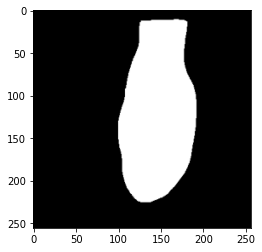

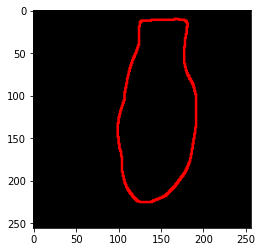

In [ ]:
import random
import math    # cos() for Rastrigin
import copy    # array-copying convenience
import sys     # max float
import numpy as np
from skimage.metrics import structural_similarity as ssim




#-------fitness functions---------
img1_pred=model.predict(img1.reshape(1,256,256,3))
def intersection_of_union(image1,image2):
    i = np.logical_and(image1, image2)
    u = np.logical_or(image1, image2)
    return i.sum() / u.sum()

def SSIM(position,D,dim):
    image_perturbed = img1.copy()
    for i in range(D):
      image_perturbed[int(position[i][1])][int(position[i][0])] = [int(position[i][2]),int(position[i][3]),int(position[i][4])]
    image_perturbed_pred=model.predict(image_perturbed.reshape(1,256,256,3))
    return ssim(np.squeeze(image_perturbed_pred[0]),np.squeeze(img1_pred),multichannel=True)



 
maxv=10
minv=-10
CR = 0.6
F = 0.8
#particle class
class Particle:
  def __init__(self, fitness, D,dim, minx, maxx, seed):
    self.rnd = random.Random(seed)
 
    # initialize position of the particle with 0.0 value
    self.position = [[0.0 for col in range(dim)] for rows in range(D)]
 
     # initialize velocity of the particle with 0.0 value
    self.velocity = [[0.0 for col in range(dim)] for rows in range(D)]
 
    # initialize best particle position of the particle with 0.0 value
    self.best_part_pos = [[0.0 for col in range(dim)] for rows in range(D)]
 
    # loop dim times to calculate random position and velocity
    # range of position and velocity is [minx, max]
    for i in range(D):
      for j in range(dim):
        self.position[i][j] = ((maxx[j] - minx[j]) *self.rnd.random() + minx[j])
        self.velocity[i][j] = ((maxv - minv) *self.rnd.random() + minv)

 
    # compute fitness of particle
    self.fitness = fitness(self.position,D,dim) # curr fitness
   #self.fitness = 1.0
    # initialize best position and fitness of this particle
    self.best_part_pos = copy.copy(self.position)
    self.best_part_fitnessVal = self.fitness # best fitness
 
# particle swarm optimization function
def de_pso(fitness, max_iter, n, D,dim, minx, maxx):
  # hyper parameters
  w = 0.729    # inertia
  c1 = 1.49445 # cognitive (particle)
  c2 = 1.49445 # social (swarm)
 
  rnd = random.Random(0)
  swarm = [Particle(fitness, D,dim, minx, maxx, i) for i in range(n)]

  # swarm = [Particle(fitness, D,dim, minx, maxx, i) for i in range(n)
 
  # compute the value of best_position and best_fitness in swarm
  best_swarm_pos = [[0.0 for col in range(dim)] for rows in range(D)]
 
  best_swarm_fitnessVal = sys.float_info.max # swarm best
 
  # computer best particle of swarm and it's fitness
  for i in range(n): # check each particle
    if swarm[i].best_part_fitnessVal < best_swarm_fitnessVal:
      best_swarm_fitnessVal = swarm[i].best_part_fitnessVal
      best_swarm_pos = copy.copy(swarm[i].best_part_pos)
 
  # main loop of DE-PSO
  Iter = 0
  while Iter <= max_iter:
    for i in range(n): # process each particle
      r = random.sample(swarm,3)
      r1 = r[0]
      r2 = r[1]
      r3 = r[2] 
      # compute new velocity of curr particle
      trial_Vector = copy.copy(swarm[i].position)
      for j in range(D):
        j_rand = random.randint(0,D-1)
        rand_j = random.random()
        if (rand_j < CR or j == j_rand):
          for k in range(dim):
            trial_Vector[j][k] = r1.position[j][k] +  F*(r2.position[j][k] - r3.position[j][k])
            if trial_Vector[j][k] < minx[k]:
              trial_Vector[j][k] = minx[k]
            elif trial_Vector[j][k] > maxx[k]:
              trial_Vector[j][k] = maxx[k]
      
      updated_fitness = fitness(trial_Vector,D,dim)
      #print(updated_fitness)

      if updated_fitness < swarm[i].fitness:
        swarm[i].position = copy.copy(trial_Vector)
        swarm[i].fitness = updated_fitness
      else:
        TX = copy.copy(swarm[i].position)
        for j in range(D):
          for k in range(dim):
            rx = rnd.random()    # randomizations
            ry = rnd.random()
            swarm[i].velocity[j][k] = (
                                  (w * swarm[i].velocity[j][k]) +
                                  (c1 * rx * (swarm[i].best_part_pos[j][k] - swarm[i].position[j][k])) + 
                                  (c2 * ry * (best_swarm_pos[j][k] -swarm[i].position[j][k]))
                                ) 
            # if velocity[k] is not in [minx, max]
            # then clip it
            if swarm[i].velocity[j][k] < minv:
              swarm[i].velocity[j][k] = minv
            elif swarm[i].velocity[j][k] > maxv:
              swarm[i].velocity[j][k] = maxv
          # compute new position using new velocity
          for k in range(dim):
            TX[j][k] += swarm[i].velocity[j][k] 
            if TX[j][k] < minx[k]:
              TX[j][k] = minx[k]
            elif TX[j][k] > maxx[k]:
              TX[j][k] = maxx[k]
   
        # compute fitness of new position
        TX_fitness = fitness(TX,D,dim)
        #print(TX_fitness)
        if TX_fitness < swarm[i].fitness:
          swarm[i].fitness = TX_fitness
          swarm[i].position = copy.copy(TX)

          
        # is new position a new best for the particle?
      if swarm[i].fitness < swarm[i].best_part_fitnessVal:
        swarm[i].best_part_fitnessVal = swarm[i].fitness
        swarm[i].best_part_pos = copy.copy(swarm[i].position)
          # is new position a new best overall?
      if swarm[i].best_part_fitnessVal < best_swarm_fitnessVal:
        best_swarm_fitnessVal = swarm[i].best_part_fitnessVal
        best_swarm_pos = copy.copy(swarm[i].best_part_pos)
    # for-each particle
    Iter += 1
  #end_while
  return [best_swarm_pos,best_swarm_fitnessVal]
# end DE-PSO
 
# Driver code for Sphere function
print("\nBegin de-pso attack on ssim function\n")
D=2000
dim = 5
fitness = SSIM
num_particles = 50
max_iter = 10
 
print("Setting num_particles = " + str(num_particles))
print("Setting max_iter    = " + str(max_iter))
print("\nStarting DE-PSO algorithm\n")
 
import cv2
from skimage import io         # Only needed for web grabbing images, use cv2.imread for local images


# Read image; find contours with hierarchy
image = load_image(rel_mask[14])
# image=image.resize(256,256,3)
im_bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(image)
plt.show()
blur = cv2.GaussianBlur(im_bw, (5,5), 0)
im_bw = cv2.Canny(blur, 10, 90)
contours, hier = cv2.findContours(im_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Define sufficient enough colors for blobs
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

# Draw all contours, and their children, with different colors
out = cv2.cvtColor(im_bw, cv2.COLOR_GRAY2BGR)
k = -1
x1=0
x2=260
y1=0
y2=260
for i, cnt in enumerate(contours):
    if (hier[0, i, 3] == -1):
        k += 1
    for x in cnt:
      for y in x:
        if(y[0]>x1):
            x1=y[0]
        
        elif(y[0]<x2):
          x2=y[0]
        if(y[1]>y1):
          y1=y[1]
        elif(y[1]<y2):
          y2=y[1]        
    
    cv2.drawContours(out, [cnt], -1, colors[k], 2)
# cv2.imshow('out', out)
plt.imshow(out)
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()
 
#[best_position,fitnessVal] = de_pso(fitness, max_iter, num_particles,D, dim, [x2,y2,0,0,0], [x1,y1,256,256,256])
 
#print("\nDE-PSO completed\n")
#print("\nBest solution found:")
#for k in range(D):
 # print(best_position[k])
# fitnessVal = fitness(best_position,D,dim)
#print("fitness of best solution = %.8f" % fitnessVal)

In [ ]:
print("\nBegin de-pso attack on ssim function\n")
D=1000
dim = 5
fitness = SSIM
num_particles = 50
max_iter = 20
fitness_arr = []
print("Setting num_particles = " + str(num_particles))
print("Setting max_iter    = " + str(max_iter))
print("\nStarting DE-PSO algorithm\n")
avg=0.0
for loop in range(0,50):
  # Read image; find contours with hierarchy
  img1 = load_image(rel_image[loop+1])
  actual_mask= load_image(rel_mask[loop+1])
  image = load_image(rel_mask[loop+1])
  # image=image.resize(256,256,3)
  im_bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  #plt.imshow(image)
  #plt.show()
  blur = cv2.GaussianBlur(im_bw, (5,5), 0)
  im_bw = cv2.Canny(blur, 10, 90)
  contours, hier = cv2.findContours(im_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # Define sufficient enough colors for blobs
  colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

  # Draw all contours, and their children, with different colors
  out = cv2.cvtColor(im_bw, cv2.COLOR_GRAY2BGR)
  k = -1
  x1=0
  x2=260
  y1=0
  y2=260
  for i, cnt in enumerate(contours):
    if (hier[0, i, 3] == -1):
      k += 1
    for x in cnt:
      for y in x:
        if(y[0]>x1):
          x1=y[0]
        elif(y[0]<x2):
          x2=y[0]
        if(y[1]>y1):
          y1=y[1]
        elif(y[1]<y2):
          y2=y[1]        
    
    # cv2.drawContours(out, [cnt], -1, colors[k], 2)
# cv2.imshow('out', out)
  # plt.imshow(out)
  # plt.show()
  cv2.waitKey(0)
  cv2.destroyAllWindows()
 
  [best_position,fitnessVal] = de_pso(fitness, max_iter, num_particles,D, dim, [x2,y2,0,0,0], [x1,y1,256,256,256])
  if(fitnessVal < 0.8):
    fitness_arr.append({i,fitnessVal})
    avg+=
 
  print("\nDE-PSO completed\n")
  print("\nBest solution found:")
  #for k in range(D):
    #print(best_position[k])
  # fitnessVal = fitness(best_position,D,dim)
  print("Image number = {loop}".format(loop=loop))
  print("fitness of best solution = %.8f" % fitnessVal)
  from PIL import Image
  import matplotlib
  # im = Image.fromarray(load_image(rel_image[1]))
  # im1 = im.crop((0, 0, 100, 255))
  image_perturbed = img1.copy()
  for i in range(D):
    image_perturbed[int(best_position[i][1])][int(best_position[i][0])] = [int(best_position[i][2]),int(best_position[i][3]),int(best_position[i][4])]

  actual_mask= load_image(rel_mask[11])
  # plotting(image_perturbed,"perturbed image")
  image_perturbed_pred=model.predict(image_perturbed.reshape(1,256,256,3))
  img1_pred=model.predict(img1.reshape(1,256,256,3))
  # img1_pred = np.squeeze((1,256,256,1))
  print("Original Image")
  plt.imshow(img1)
  plt.show()

  print("Perturbed Image")
  plt.imshow(image_perturbed)
  plt.show()

  imgam=color.gray2rgb(image_perturbed_pred[0].reshape(256,256))
  for i in range(D):
    imgam[int(best_position[i][1])][int(best_position[i][0])] = [int(best_position[i][2]),int(best_position[i][3]),int(best_position[i][4])]
  im = Image.fromarray(imgam.astype(np.uint8))
  print("Perturbation Points")
  plt.imshow(im)
  plt.show()
  plotting(image_perturbed_pred, "Adverserial Mask")
  plotting(img1_pred, "Expected mask")
print(fitness_arr)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
a=[{0.5884598044619659, 1}, {0.7976708911010018, 1}, {0.7321044079487329, 1}, {0.5716341526846096, 1}, {0.6602784236848385, 1}, {0.5214808391496049, 1}, {0.7611239741712326, 1}, {0, 0.6981161403198579}, {0, 0.7935223051649949}, {0, 0.7621050720517456}, {0.7743365237430531, 1}, {0.6798405174504949, 1}, {0, 0.538346069302837}, {0.7821891600989077, 1}, {0.7935444927453703, 1}, {0.6910687120242216, 1}, {0.7932217134472116, 1}, {0.7996182920501622, 1}, {0.7636723875798161, 1}, {0.6509683717492603, 1}, {0.5931462876652422, 1}, {0.7534434696869307, 1}, {0.6068569502414074, 1}, {0.7267441958023875, 1}, {0.7621645783881539, 1}]
avg=0.0
for i in a:
  if(list(i)[0]==0):
    avg=avg+list(i)[0]
  else:
    avg=avg+list(i)[0]
print(avg/len(a))

0.5921427258349842


Original Image


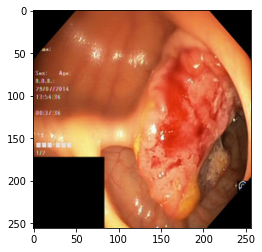

Perturbed Image


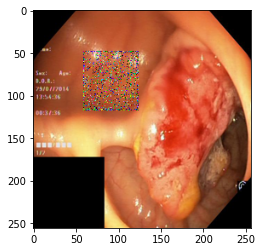

Perturbation Points


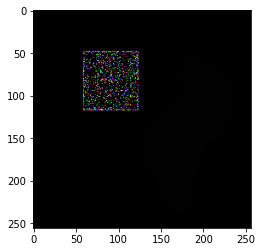

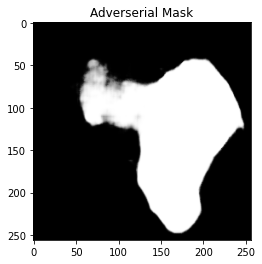

<class 'numpy.ndarray'>
(256, 256, 1)


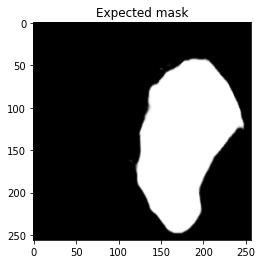

In [ ]:
from PIL import Image
import matplotlib
# im = Image.fromarray(load_image(rel_image[1]))
# im1 = im.crop((0, 0, 100, 255))
image_perturbed = img1.copy()
for i in range(D):
    image_perturbed[int(best_position[i][1])][int(best_position[i][0])] = [int(best_position[i][2]),int(best_position[i][3]),int(best_position[i][4])]

actual_mask= load_image(rel_mask[11])
# plotting(image_perturbed,"perturbed image")
image_perturbed_pred=model.predict(image_perturbed.reshape(1,256,256,3))
img1_pred=model.predict(img1.reshape(1,256,256,3))
# img1_pred = np.squeeze((1,256,256,1))
print("Original Image")
plt.imshow(img1)
plt.show()

print("Perturbed Image")
plt.imshow(image_perturbed)
plt.show()

imgam=color.gray2rgb(image_perturbed_pred[0].reshape(256,256))
for i in range(D):
    imgam[int(best_position[i][1])][int(best_position[i][0])] = [int(best_position[i][2]),int(best_position[i][3]),int(best_position[i][4])]
# plt.imshow(imgam)
# plt.show()

im = Image.fromarray(imgam.astype(np.uint8))
print("Perturbation Points")
plt.imshow(im)
plt.show()
im.save("img1_pso_am_100.jpg")


plotting(image_perturbed_pred, "Adverserial Mask")
plt.savefig("filename2.jpg")
print(type(image_perturbed_pred))
print(image_perturbed_pred[0].shape)
cv2.imwrite('filename.jpeg', image_perturbed_pred[0])
# imk = Image.fromarray((image_perturbed_pred[0] * 255).astype(np.uint8))
# imk.save("your_file.jpeg")
plotting(img1_pred, "Expected mask")


In [ ]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs